# ThriftyDagger 

## TD: Metaworld

In [5]:
# reload notebook
%load_ext autoreload
%autoreload 2

import os
import sys 
sys.path.append("/scr/aliang80/changepoint_aug/")
import numpy as np
import click
import tqdm
from pathlib import *
import matplotlib.pyplot as plt
from cp_detection.offline_thriftydagger import thrifty, Ensemble

In [2]:
from imitation.data import serialize
from imitation.data.types import TrajectoryWithRew
from env_utils import create_single_env
from metaworld.policies import *

env_name = "metaworld-assembly-v2"
# env_name = "metaworld-drawer-open-v2"
noise_std = 0
env = create_single_env(env_name, seed=521, image_based=False, noise_std=noise_std)
obs, _ = env.reset()
obs.shape

/scr/aliang80/metaworld_sac/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(39,)

In [3]:
root_dir = "/scr/aliang80/changepoint_aug"
dataset_file = f"datasets/expert_dataset/image_False/{env_name}_100_noise_0"
# load base expert dataset
print("load dataset from ", dataset_file)
dataset_file = os.path.join(root_dir, dataset_file)
full_dataset = serialize.load(dataset_file)
input_data = full_dataset[:30]
print("number of expert trajectories: ", len(input_data))

load dataset from  datasets/expert_dataset/image_False/metaworld-assembly-v2_100_noise_0
number of expert trajectories:  30


In [113]:
# run thrifty and save trained policies
thrifty(
    env, 
    num_nets=5, 
    bc_epochs=5, 
    batch_size=100, 
    pi_lr=1e-3,
    input_data=input_data
)

Ensemble(
  (q1): MLPQFunction(
    (q): Sequential(
      (0): Linear(in_features=43, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Sigmoid()
    )
  )
  (q2): MLPQFunction(
    (q): Sequential(
      (0): Linear(in_features=43, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Sigmoid()
    )
  )
)
[MLPActor(
  (pi): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=4, bias=True)
    (5): Tanh()
  )
), MLPActor(
  (pi): Sequential(
    (0): Linear(in_features=39, out_features=256, bias=True)
    (1): ReLU()
    (2): Linea

In [36]:
import torch
actor_critic = Ensemble
device = "cuda"
num_nets = 5 
ac_kwargs = dict()
ac = actor_critic(
    env.observation_space, env.action_space, device, num_nets=num_nets, **ac_kwargs
)
print(ac.q1.q[0].weight.sum())
print(ac.pis[0].pi[0].weight.sum())
# print(torch.load("/scr/aliang80/changepoint_aug/results/metaworld/thriftydagger_ac.pkl"))
ac.load_state_dict(torch.load("/scr/aliang80/changepoint_aug/results/metaworld/thriftydagger_ac.pkl"))
print(ac.q1.q[0].weight.sum())
print(ac.pis[0].pi[0].weight.sum())
print(ac.pis[1].pi[0].weight.sum())

tensor(2.6382, device='cuda:0', grad_fn=<SumBackward0>)
tensor(12.5901, device='cuda:0', grad_fn=<SumBackward0>)
tensor(1.1899, device='cuda:0', grad_fn=<SumBackward0>)
tensor(11.4896, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-9.8671, device='cuda:0', grad_fn=<SumBackward0>)


Text(0.5, 0, 'Timestep')

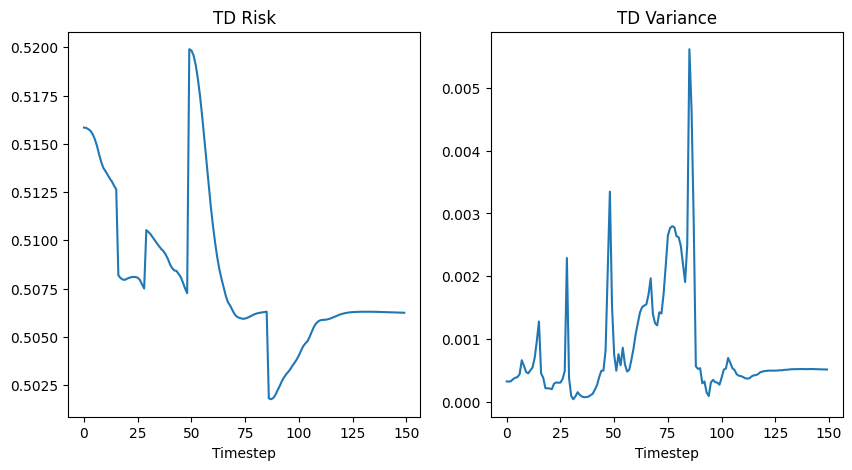

In [59]:
risk = []
variance = []
indx = 67
for timestep in range(full_dataset[indx].acts.shape[0]):
    obs = torch.from_numpy(full_dataset[indx].obs[timestep])
    act = torch.from_numpy(full_dataset[indx].acts[timestep])
    # print(timestep, " : ", 1 - ac.safety(obs, act), ac.variance(obs))
    risk.append(1 - ac.safety(obs, act))
    variance.append(ac.variance(obs))
sorted_risk = np.argsort(risk)
sorted_variance = np.argsort(variance)
# print(sorted_variance)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(np.arange(len(risk)), risk)
ax0.set_title("TD Risk")
ax0.set_xlabel("Timestep")
ax1.plot(np.arange(len(variance)), variance)
ax1.set_title("TD Variance")
ax1.set_xlabel("Timestep")

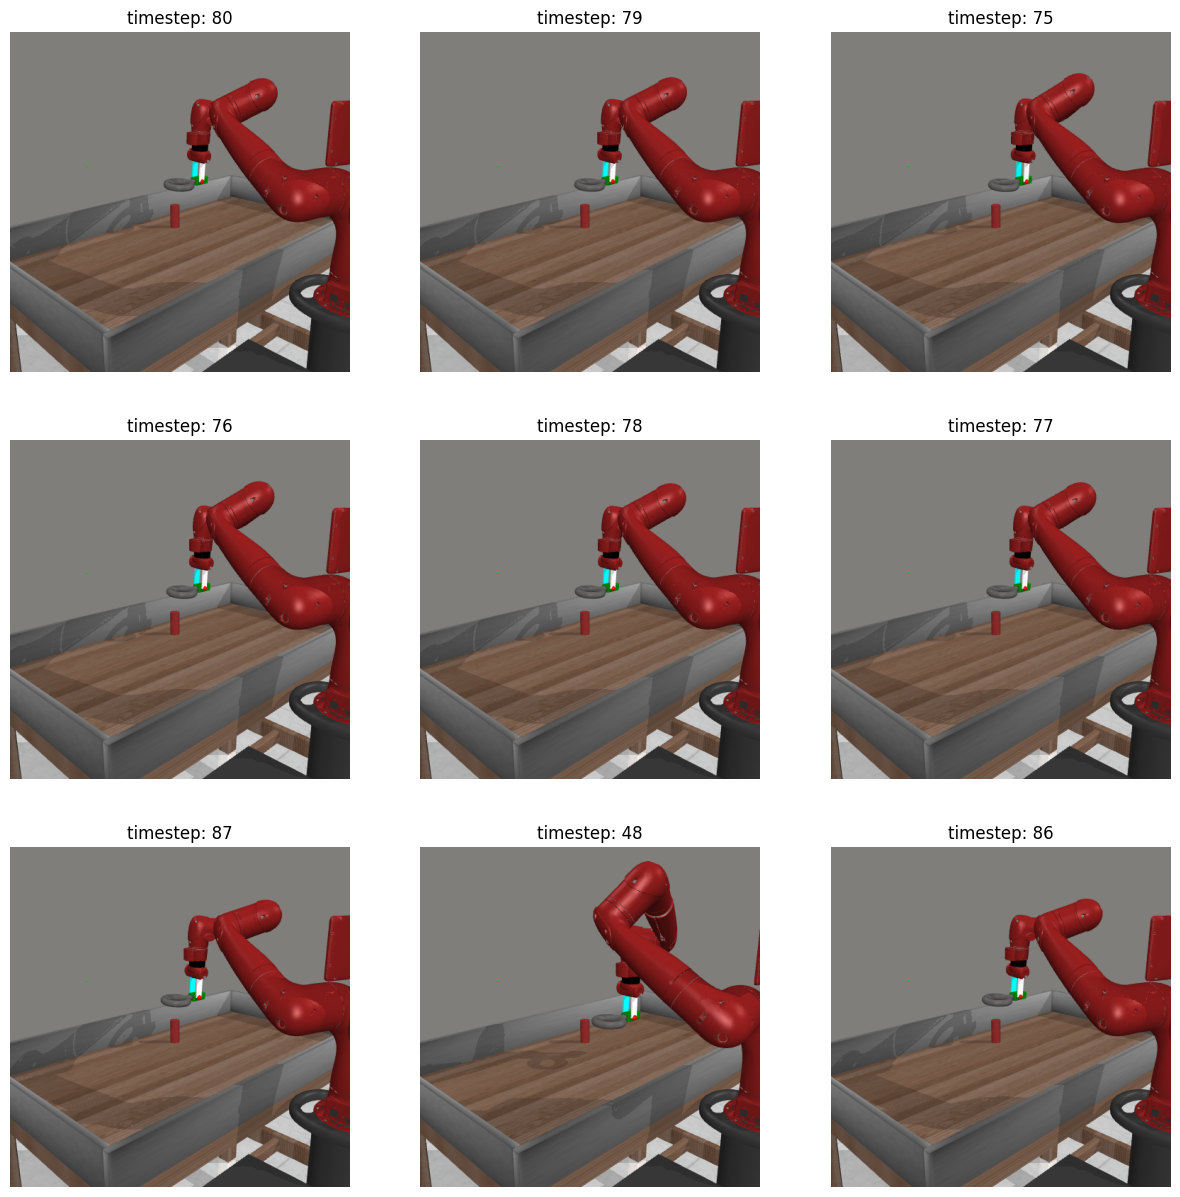

In [64]:
top_10 = sorted_variance[-10:]

# create a grid of 3 x 3 plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    timestep = top_10[i]
    info = full_dataset[indx].infos
    env.unwrapped._freeze_rand_vec = True
    qpos = info[timestep]["qpos"]
    qvel = info[timestep]["qvel"]
    env.unwrapped._last_rand_vec = info[timestep]["last_rand_vec"]
    env.unwrapped._target_pos = info[timestep]["task"]
    env.reset_model()
    env.set_env_state((qpos, qvel))
    # env.unwrapped._prev_obs = prev_obs
    os.environ["MUJOCO_GL"] = "egl"
    img = env.render()
    from scipy import ndimage
    img = ndimage.rotate(img, 180)
    ax.imshow(img)
    ax.set_title(f"timestep: {timestep}")
    ax.axis("off")

## TD: Robosuite

In [18]:
import sys
import h5py
sys.path.append("/scr/aliang80/diffusion_policy/")
from typing import List
from tqdm import tqdm
import numpy as np
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.file_utils as FileUtils
from diffusion_policy.common.replay_buffer import ReplayBuffer
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.dataset.robomimic_replay_lowdim_dataset import _data_to_obs
from diffusion_policy.env.robomimic.robomimic_lowdim_wrapper import (
    RobomimicLowdimWrapper,
)
dataset_path = "/scr/aliang80/diffusion_policy/data/robomimic/datasets/square/ph/low_dim.hdf5"

replay_buffer = ReplayBuffer.create_empty_numpy()

obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
abs_action = False 
rotation_transformer = None

states = []
with h5py.File(dataset_path) as file:
    demos = file['data']
    for i in tqdm(range(len(demos)), desc="Loading hdf5 to ReplayBuffer"):
        demo = demos[f'demo_{i}']
        episode = _data_to_obs(
            raw_obs=demo['obs'],
            raw_actions=demo['actions'][:].astype(np.float32),
            obs_keys=obs_keys,
            abs_action=abs_action,
            rotation_transformer=rotation_transformer)
        episode["states"] = demo["states"]
        replay_buffer.add_episode(episode)


Loading hdf5 to ReplayBuffer:   0%|          | 0/200 [00:00<?, ?it/s]

Loading hdf5 to ReplayBuffer: 100%|██████████| 200/200 [00:00<00:00, 665.33it/s]


In [2]:
# sample random trajectories from replay buffer
num_traj = 150
from dataclasses import dataclass
@dataclass 
class TrajectoryWithRew:
    obs: np.ndarray
    acts: np.ndarray
    # rews: np.ndarray
    # terminal: np.ndarray

input_data = []
for indx in range(num_traj):
    episode = replay_buffer.get_episode(indx)
    print(episode['obs'].shape, episode['action'].shape)
    traj = TrajectoryWithRew(
        obs = episode['obs'],
        acts = episode['action'],
    )
    input_data.append(traj)
print(len(input_data))

(127, 23) (127, 7)
(123, 23) (123, 7)
(124, 23) (124, 7)
(149, 23) (149, 7)
(154, 23) (154, 7)
(144, 23) (144, 7)
(144, 23) (144, 7)
(150, 23) (150, 7)
(160, 23) (160, 7)
(152, 23) (152, 7)
(134, 23) (134, 7)
(156, 23) (156, 7)
(133, 23) (133, 7)
(153, 23) (153, 7)
(152, 23) (152, 7)
(141, 23) (141, 7)
(174, 23) (174, 7)
(174, 23) (174, 7)
(127, 23) (127, 7)
(165, 23) (165, 7)
(145, 23) (145, 7)
(179, 23) (179, 7)
(130, 23) (130, 7)
(176, 23) (176, 7)
(155, 23) (155, 7)
(158, 23) (158, 7)
(182, 23) (182, 7)
(180, 23) (180, 7)
(136, 23) (136, 7)
(183, 23) (183, 7)
(134, 23) (134, 7)
(139, 23) (139, 7)
(142, 23) (142, 7)
(120, 23) (120, 7)
(129, 23) (129, 7)
(174, 23) (174, 7)
(147, 23) (147, 7)
(160, 23) (160, 7)
(114, 23) (114, 7)
(128, 23) (128, 7)
(140, 23) (140, 7)
(134, 23) (134, 7)
(186, 23) (186, 7)
(122, 23) (122, 7)
(125, 23) (125, 7)
(180, 23) (180, 7)
(132, 23) (132, 7)
(148, 23) (148, 7)
(170, 23) (170, 7)
(167, 23) (167, 7)
(171, 23) (171, 7)
(127, 23) (127, 7)
(111, 23) (1

In [21]:
def create_env(env_meta, obs_keys):
    ObsUtils.initialize_obs_modality_mapping_from_dict({"low_dim": obs_keys})
    env = EnvUtils.create_env_from_metadata(
        env_meta=env_meta,
        render=False,
        # only way to not show collision geometry
        # is to enable render_offscreen
        # which uses a lot of RAM.
        render_offscreen=False,
        use_image_obs=False,
    )
    return env

env_meta = FileUtils.get_env_metadata_from_dataset("/scr/aliang80/diffusion_policy/data/robomimic/datasets/square/ph/low_dim_abs.hdf5")
# rotation_transformer = None
obs_keys = ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos']
env_meta["env_kwargs"]["controller_configs"]["control_delta"] = False
# rotation_transformer = RotationTransformer("axis_angle", "rotation_6d")
env = create_env(env_meta, obs_keys)
wrapped_env = RobomimicLowdimWrapper(env)
print(wrapped_env.action_space, wrapped_env.observation_space)

Created environment with name NutAssemblySquare
Action size is 7
ROBOMIMIC WARNING(
    No environment version found in dataset!
    Cannot verify if dataset and installed environment versions match
)
Box([-1 -1 -1 -1 -1 -1 -1], [1 1 1 1 1 1 1], (7,), int64) Box([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], (23,), float64)


In [6]:
thrifty(
    wrapped_env, 
    num_nets=5,
    bc_epochs=10,
    batch_size=1000,
    pi_lr=3e-4,
    robosuite=True,
    input_data=input_data,
    model_ckpt_path="/scr/aliang80/changepoint_aug/results/robosuite/thriftydagger_ac.pkl",
)

Ensemble(
  (pis): Sequential(
    (0): MLPActor(
      (pi): Sequential(
        (0): Linear(in_features=23, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=7, bias=True)
        (5): Tanh()
      )
    )
    (1): MLPActor(
      (pi): Sequential(
        (0): Linear(in_features=23, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=7, bias=True)
        (5): Tanh()
      )
    )
    (2): MLPActor(
      (pi): Sequential(
        (0): Linear(in_features=23, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=7, bias=True)
        (5): Tanh()
      )
    )
    (3): MLPActor(
      (pi): Se

In [7]:
# Load the trained policy
import torch
actor_critic = Ensemble
device = "cuda"
num_nets = 5 
ac_kwargs = dict()
ac = actor_critic(
    wrapped_env.observation_space, wrapped_env.action_space, device, num_nets=num_nets, **ac_kwargs
)
print(ac.q1.q[0].weight.sum())
print(ac.pis[0].pi[0].weight.sum())

ac.load_state_dict(torch.load("/scr/aliang80/changepoint_aug/results/robosuite/thriftydagger_ac.pkl"))
print(ac.q1.q[0].weight.sum())
print(ac.pis[0].pi[0].weight.sum())


tensor(-21.8953, device='cuda:0', grad_fn=<SumBackward0>)
tensor(-8.5443, device='cuda:0', grad_fn=<SumBackward0>)
tensor(6.7000, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2.8816, device='cuda:0', grad_fn=<SumBackward0>)


149


Text(0.5, 0, 'Timestep')

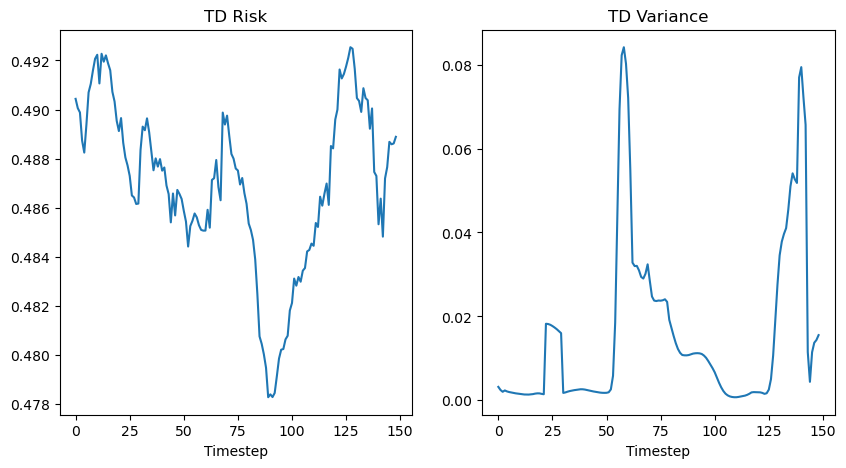

In [49]:
risk = []
variance = []
episode_indx = 155
episode = replay_buffer.get_episode(episode_indx)
print(episode["obs"].shape[0])
for timestep in range(episode["obs"].shape[0]):
    obs = torch.from_numpy(episode["obs"][timestep])
    act = torch.from_numpy(episode["action"][timestep])
    # print(timestep, " : ", 1 - ac.safety(obs, act), ac.variance(obs))
    risk.append(1 - ac.safety(obs, act))
    variance.append(ac.variance(obs))
sorted_variance = np.argsort(variance)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax0.plot(np.arange(len(risk)), risk)
ax0.set_title("TD Risk")
ax0.set_xlabel("Timestep")
ax1.plot(np.arange(len(variance)), variance)
ax1.set_title("TD Variance")
ax1.set_xlabel("Timestep")

149
[ 58  57  59 140 139 141  60  56 142  61 136 137 138 135 134  55]


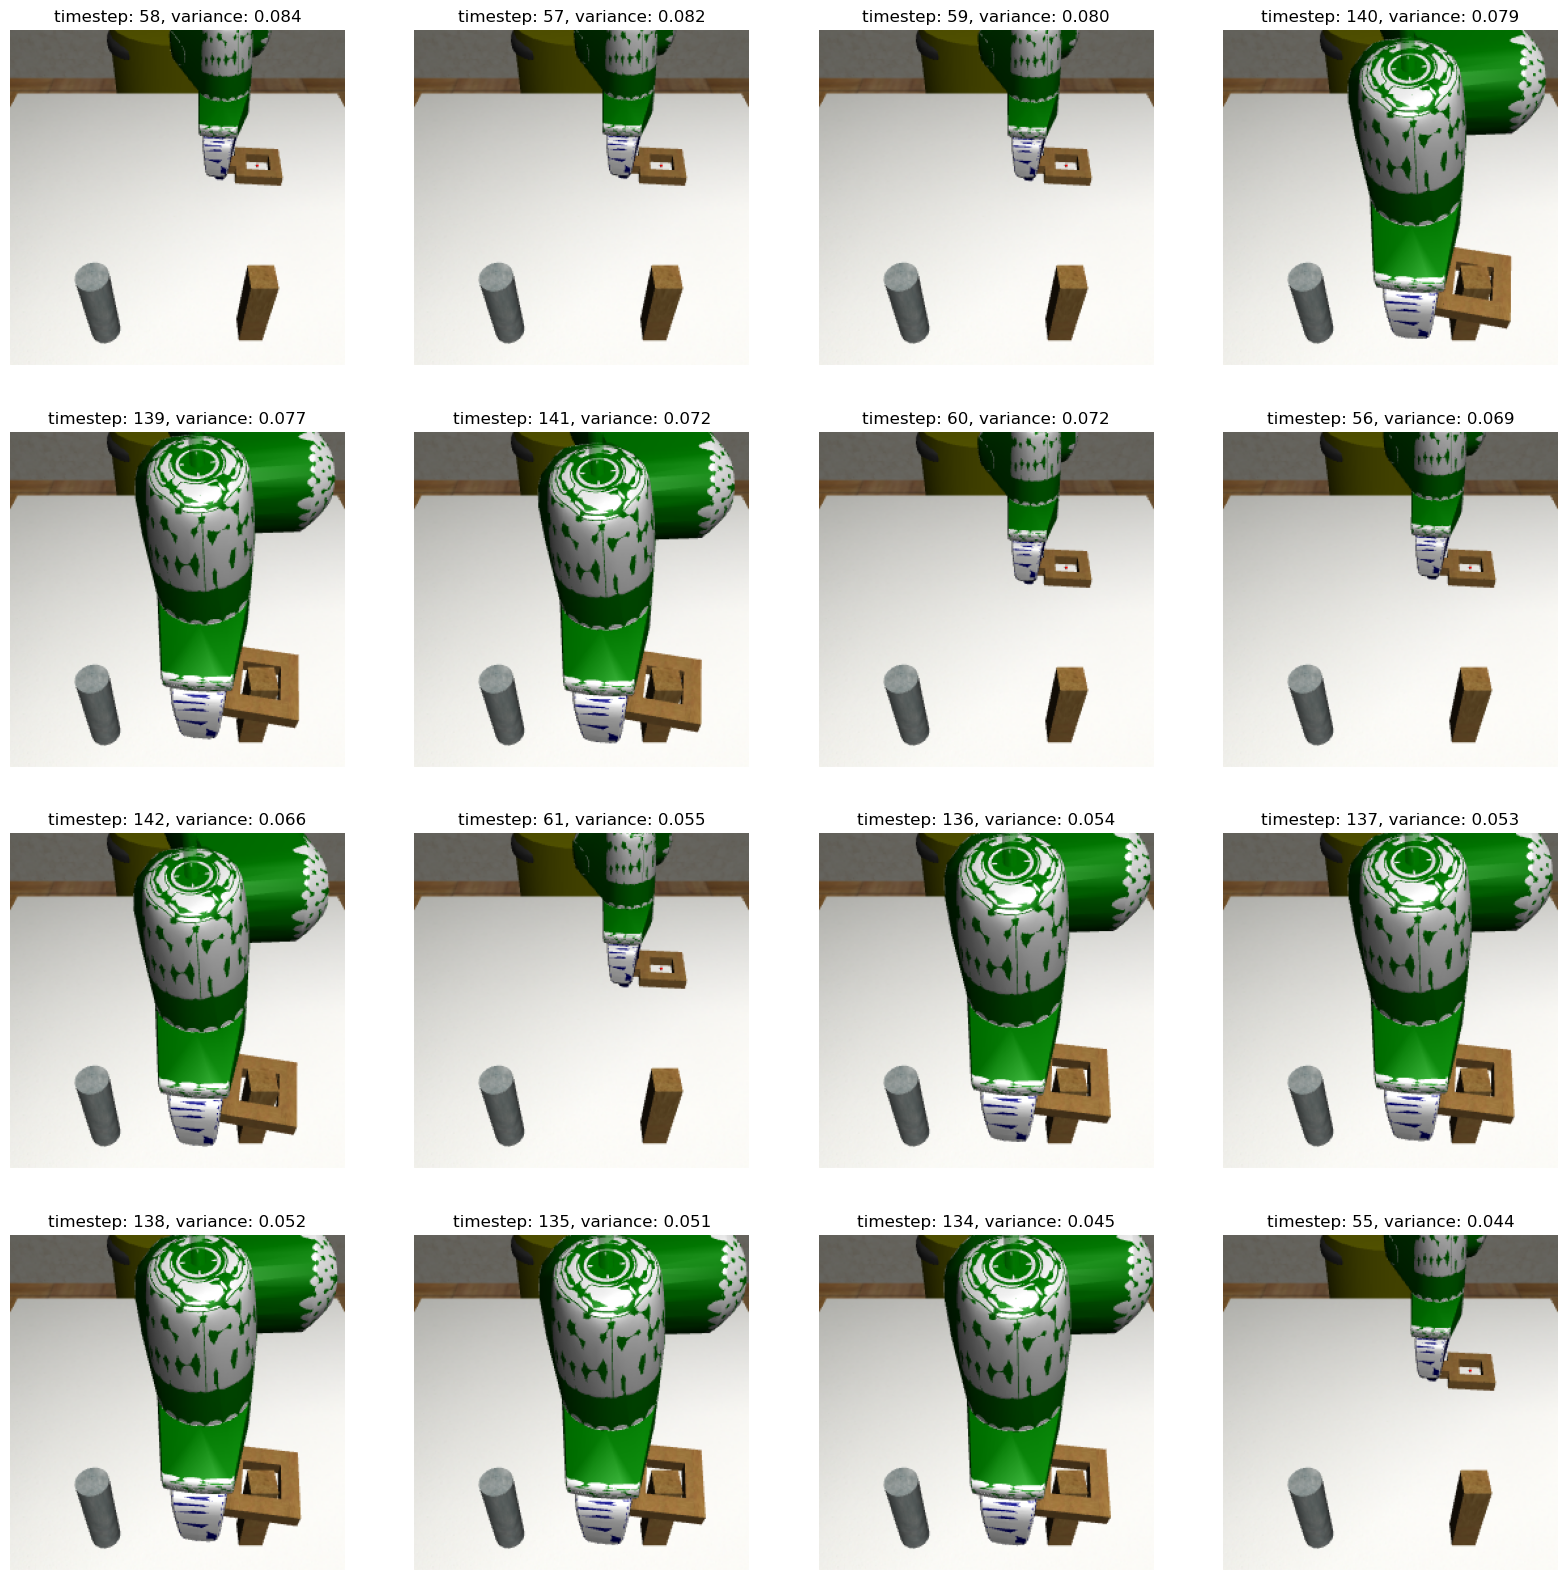

In [50]:
risk = []
variance = []
episode_indx = 155
episode = replay_buffer.get_episode(episode_indx)
print(episode["obs"].shape[0])
for timestep in range(episode["obs"].shape[0]):
    obs = torch.from_numpy(episode["obs"][timestep])
    act = torch.from_numpy(episode["action"][timestep])
    # print(timestep, " : ", 1 - ac.safety(obs, act), ac.variance(obs))
    risk.append(1 - ac.safety(obs, act))
    variance.append(ac.variance(obs))
sorted_variance = np.argsort(variance)

timesteps = sorted_variance[-16:][::-1]
print(timesteps)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    timestep = timesteps[i]
    state = replay_buffer.get_episode(episode_indx)["states"][timestep]
    obs = wrapped_env.env.reset_to({"states": state})
    frame = wrapped_env.render(mode="rgb_array")

    ax.set_title(f"timestep: {timestep}, variance: {variance[timestep]:.3f}")
    ax.imshow(frame)
    ax.axis("off")

## Copycat: MetaWorld

In [83]:
from cp_detection.copycat_policy import train_ape_model, ActionDataset, ActionModel, train_ape_model, weighted_loss

prev_actions = 4
curr_actions = 1
root_dir = "/scr/aliang80/changepoint_aug"
dataset_file = "datasets/expert_dataset/image_False/assembly-v2_100_noise_0"
# load base expert dataset
print("load dataset from ", dataset_file)
dataset_file = os.path.join(root_dir, dataset_file)
input_data = serialize.load(dataset_file)[:30]
print("number of expert trajectories: ", len(input_data))
actions = [input_data[i].acts for i in range(len(input_data))]
model_layer_neurons = [300]
train_ape_model(actions, prev_actions, curr_actions, epoch_num=100, model_layer_neurons=model_layer_neurons, if_save=True)

load dataset from  datasets/expert_dataset/image_False/assembly-v2_100_noise_0
number of expert trajectories:  30
action dim:  4
0 4
1 5
2 6
3 7
4 8
5 9
6 10
7 11
8 12
9 13
10 14
11 15
12 16
13 17
14 18
15 19
16 20
17 21
18 22
19 23
20 24
21 25
22 26
23 27
24 28
25 29
26 30
27 31
28 32
29 33
30 34
31 35
32 36
33 37
34 38
35 39
36 40
37 41
38 42
39 43
40 44
41 45
42 46
43 47
44 48
45 49
46 50
47 51
48 52
49 53
50 54
51 55
52 56
53 57
54 58
55 59
56 60
57 61
58 62
59 63
60 64
61 65
62 66
63 67
64 68
65 69
66 70
67 71
68 72
69 73
70 74
71 75
72 76
73 77
74 78
75 79
76 80
77 81
78 82
79 83
80 84
81 85
82 86
83 87
84 88
85 89
86 90
87 91
88 92
89 93
90 94
91 95
92 96
93 97
94 98
95 99
0 4
1 5
2 6
3 7
4 8
5 9
6 10
7 11
8 12
9 13
10 14
11 15
12 16
13 17
14 18
15 19
16 20
17 21
18 22
19 23
20 24
21 25
22 26
23 27
24 28
25 29
26 30
27 31
28 32
29 33
30 34
31 35
32 36
33 37
34 38
35 39
36 40
37 41
38 42
39 43
40 44
41 45
42 46
43 47
44 48
45 49
46 50
47 51
48 52
49 53
50 54
51 55
52 56
53 57
54 

ActionModel(
  (main): Sequential(
    (0): Linear(in_features=16, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=300, out_features=4, bias=True)
  )
)

0 4
1 5
2 6
3 7
4 8
5 9
6 10
7 11
8 12
9 13
10 14
11 15
12 16
13 17
14 18
15 19
16 20
17 21
18 22
19 23
20 24
21 25
22 26
23 27
24 28
25 29
26 30
27 31
28 32
29 33
30 34
31 35
32 36
33 37
34 38
35 39
36 40
37 41
38 42
39 43
40 44
41 45
42 46
43 47
44 48
45 49
46 50
47 51
48 52
49 53
50 54
51 55
52 56
53 57
54 58
55 59
56 60
57 61
58 62
59 63
60 64
61 65
62 66
63 67
64 68
65 69
66 70
67 71
68 72
69 73
70 74
71 75
72 76
73 77
74 78
75 79
76 80
77 81
78 82
79 83
80 84
81 85
82 86
83 87
84 88
85 89
86 90
87 91
88 92
89 93
90 94
91 95
92 96
93 97
94 98
95 99
0 4
1 5
2 6
3 7
4 8
5 9
6 10
7 11
8 12
9 13
10 14
11 15
12 16
13 17
14 18
15 19
16 20
17 21
18 22
19 23
20 24
21 25
22 26
23 27
24 28
25 29
26 30
27 31
28 32
29 33
30 34
31 35
32 36
33 37
34 38
35 39
36 40
37 41
38 42
39 43
40 44
41 45
42 46
43 47
44 48
45 49
46 50
47 51
48 52
49 53
50 54
51 55
52 56
53 57
54 58
55 59
56 60
57 61
58 62
59 63
60 64
61 65
62 66
63 67
64 68
65 69
66 70
67 71
68 72
69 73
70 74
71 75
72 76
73 77
74 78
75 79


Text(0, 0.5, 'Action Prediction Error (MSE)')

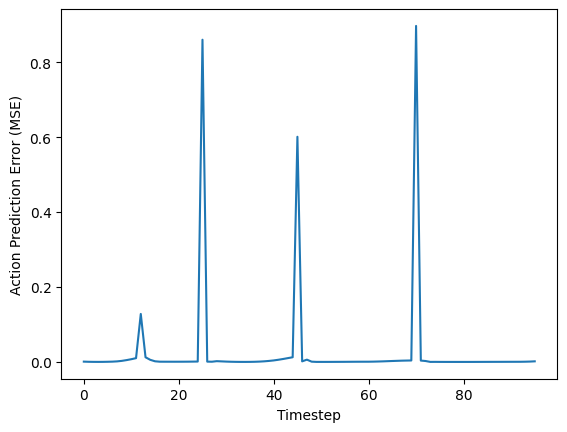

In [85]:
from cp_detection.copycat_policy import train_ape_model, ActionDataset, ActionModel, train_ape_model, weighted_loss

action_dim = 4
model_path = "/scr/aliang80/changepoint_aug/results/action_correlation/checkpoints/prev4-curr1-layer300.pkl"
model = ActionModel(
    input_dim=prev_actions * action_dim,
    output_dim=curr_actions * action_dim,
    neurons=model_layer_neurons,
)
model.cuda()
model.load_state_dict(torch.load(model_path)["state_dict"])
model.eval()

dataset = ActionDataset(actions, prev_actions, curr_actions)


ape = []
for i in range(100):
    x, y, index = dataset[i]
    traj_indx, timestep = index
    pred = model(x.cuda())
    loss = weighted_loss(pred, y.cuda())
    if traj_indx == 0: 
        ape.append(loss.item())
        print(loss.item())
        
plt.plot(np.arange(len(ape)), ape) 
plt.xlabel("Timestep")
plt.ylabel("Action Prediction Error (MSE)")